# Classification_lithops
Based on a train model we make a clasification of raster images thanks to lithops.

### Import libraries

In this section we import the necessary libraries for the realization of our classification

In [9]:
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from shapely.geometry import mapping
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.merge import merge
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.windows import Window
from rasterio.plot import reshape_as_raster
from rasterio.plot import reshape_as_image
import matplotlib.pyplot as plt
import numpy as np
import lithops
import pandas
import pickle
import joblib
import time
import glob
import os

print("Libraries imported succesfully")

Libraries imported succesfully


### 7. Import  trained model 

**Importing model** through:

- pickle
- joblib


In [81]:
loaded_model = pickle.load(open(tmp + '/COS/' + filename, 'rb'))
#result = loaded_model.score(X, y)
#print(result)

print("Succesfully imported!")

Succesfully imported!


In [85]:
loaded_model = joblib.load(tmp + '/COS/' + filename2)
# result = loaded_model.score(X, y)
# print(result)

print("Succesfully imported!")

Succesfully imported!


# Serverless Implementation - Lithops

A execution using lithops where a trained model will be applied to a new image to extract the different classes. This will escalate in several ways:

- Applying the same model to several images in parallel.
- Apply different models to the same image to study which one offers the best results.


In [86]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import lithops
import pickle
import os
warnings.filterwarnings('ignore')

Config lithops

In [87]:
config = {'serverless': {'backend': 'ibm_cf'},
          'ibm_cf':  {'serverless': {'backend': 'ibm_cf'},
                      'endpoint': 'https://eu-gb.functions.cloud.ibm.com',
                      'namespace': 'cloudbutton@uvigo.es_dev',
                      'api_key': 'c8a9e3ec-51c9-413b-ac23-e10c3ccb71e1:k3GoGB7GRgyNFYI3ob97GAuKt8ORPYJ9eWjCfIygD0d2xeR9aowjaQlvgm7HhlPm'},
          'ibm_cos': {'endpoint': 'https://s3.eu-gb.cloud-object-storage.appdomain.cloud', #https://s3.eu.cloud-object-storage.appdomain.cloud
                      'private_endpoint': 'https://s3.private.eu-gb.cloud-object-storage.appdomain.cloud',
                      'api_key' : '0GRleyXkQsvdhokMlmI0Ve-p7WxAhnKCJz9F-M7bu9qe'},
          'lithops' : {'storage_bucket' : 'bucket-gerard-eu-gb'}}

In [91]:
def map_model(obj, ibm_cos): # pasar aqui un diccionario con el modelo y la imagen
    print(obj.key + '+' + obj.bucket)
    import io
    import rasterio
    from rasterio.plot import reshape_as_image
    import joblib
    with rasterio.open(obj.data_stream) as src:
        img = src.read()#[:, 150: 200, 150 : 250]  #posicion    col_off, row_off, width, height
        reshaped_img = reshape_as_image(img)
        shapefile = ibm_cos.get_object(Bucket=obj.bucket, Key='modelos/finalized_model_joblib.sav')['Body']
        loaded_model = joblib.load(io.BytesIO(shapefile.read())) #also (filename2) => Funciona
        # For each pixel of our we perform a prediction
        prediction = loaded_model.predict(reshaped_img.reshape(-1, 3))
        #we reshape our classified image in a 2d matrix to be able to see it
        prediction = prediction.reshape(reshaped_img[:, :, 0].shape)
        #We use the previously performed function to convert the strings that the shapefile initially gave us into a numpy
        prediction[prediction == 'agua'] = 0
        prediction[prediction == 'bosque'] = 1
        prediction[prediction == 'cultivos'] = 2
        prediction[prediction == 'urbano'] = 3
        prediction= (prediction.astype(int))
        y = prediction.astype(np.int32)
    return  prediction
    
def reduce_prediction(Y):
    SalidaR = rasterio.open(path + 'rasteriop.tif','w',
                       driver='Gtiff',
                       width = 1000,
                       height = 500,
                       count=1,
                       crs = full_data.crs,  # TODO: Check this => full_dataset.crs,
                       transform = full_data.transform, # TODO: Check this => full_dataset.crs,
                       dtype='int32')
    for y in Y:
        path = 'cos://bucket-gerard-eu-gb/imagenes/'
        SalidaR.write(y,1)
        SalidaR.close()
    return SalidaR


In [ ]:
iterdata have the raster images to be parallel clasified.

In [92]:
iterdata  = ['cos://bucket-gerard-eu-gb/imagenes/valenciana_704000.0-4400000.0_comunidad_mask.tif',
             'cos://bucket-gerard-eu-gb/imagenes/valenciana_704000.0-4416000.0_comunidad_mask.tif',
             'cos://bucket-gerard-eu-gb/imagenes/valenciana_704000.0-4432000.0_comunidad_mask.tif',
             'cos://bucket-gerard-eu-gb/imagenes/valenciana_704000.0-4448000.0_comunidad_mask.tif',
             'cos://bucket-gerard-eu-gb/imagenes/valenciana_704000.0-4464000.0_comunidad_mask.tif',
             'cos://bucket-gerard-eu-gb/imagenes/valenciana_704000.0-4480000.0_comunidad_mask.tif',
             'cos://bucket-gerard-eu-gb/imagenes/valenciana_704000.0-4400000.0_comunidad_mask.tif']

Lithops v2.2.3 init for IBM Cloud Functions - Namespace: cloudbutton@uvigo.es_dev - Region: eu_gb
ExecutorID 9f4680/1 | JobID M000 - Selected Runtime: mavsonnen/lithops-py37:latest - 2048MB 
ExecutorID 9f4680/1 | JobID M000 - Uploading function and data - Total: 2.8KiB
ExecutorID 9f4680/1 | JobID M000 - Starting function invocation: map_model() - Total: 7 activations
ExecutorID 9f4680/1 - Getting results...



ExecutorID 9f4680/1 - Cleaning temporary data


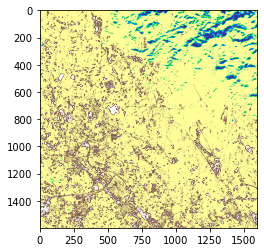

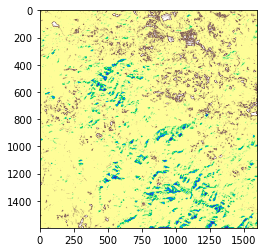

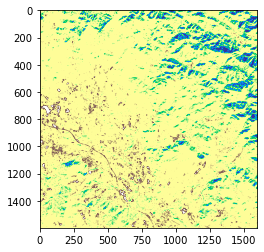

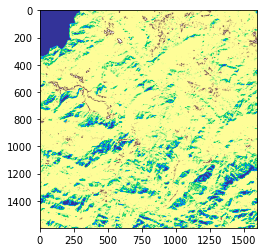

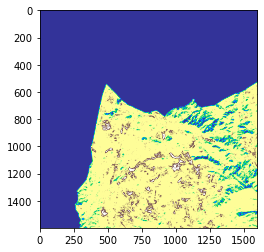

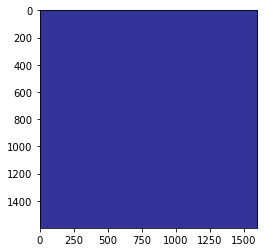

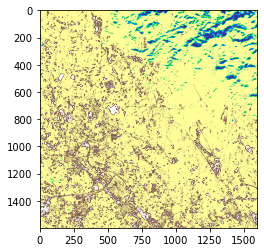

In [93]:
if __name__ == "__main__":
    # For Python 3.7 use mavsonnen/lithops-py37:latest + For Python 3.7 use mavsonnen/jdsampe:nogdal
    fexec = lithops.FunctionExecutor(config=config,runtime='mavsonnen/lithops-py37:latest', runtime_memory=2048)
    fexec.map(map_model, iterdata)# data_location)
    results = fexec.get_result()
    for img in results:
        show(img, cmap='terrain')